In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
import neural_lib62 as nl
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
)
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt
import networkx as nx
plt.rcParams["figure.facecolor"] = (1, 1, 1, 1)
import warnings
warnings.filterwarnings("ignore")

In [2]:
NUMBER = 2
df_bin = pd.read_csv("another_baseline.csv", index_col=0)

In [3]:
df_bin = df_bin.set_index(np.arange(len(df_bin)).astype(str))

In [4]:
y = df_bin['HeartDisease']
X = df_bin.drop(columns=['HeartDisease'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Concept Lattice

In [5]:
def build_lattice(X_train):
    K_train = FormalContext.from_pandas(X_train)
    L = ConceptLattice.from_context(K_train, algo="Sofia", is_monotone=True)
    print(len(L))
    for c in L:
        y_preds = np.zeros(K_train.n_objects)
        y_preds[list(c.extent_i)] = 1
        c.measures["f1_score"] = f1_score(y_train, y_preds)
        c.measures["accuracy"] = accuracy_score(y_train, y_preds)
        c.measures["recall"] = recall_score(y_train, y_preds)
        c.measures["precision"] = precision_score(y_train, y_preds)
    return K_train, L

In [6]:
K_train, L = build_lattice(X_train)

100


Please, modify the ``pos`` dictionary parameter manually. You can obtain the default ``pos`` via Mover.initialize_pos(...) function.

The problematic edges and nodes (in the form of {edge: overlapped nodes indexes}) are:
{(6, 35): frozenset({15}), (21, 78): frozenset({69}), (21, 83): frozenset({28}), (21, 86): frozenset({67}), (31, 38): frozenset({17}), (62, 78): frozenset({98}), (70, 73): frozenset({84}), (80, 99): frozenset({74, 82, 78}), (83, 99): frozenset({80, 74, 82, 78}), (93, 99): frozenset({86})}


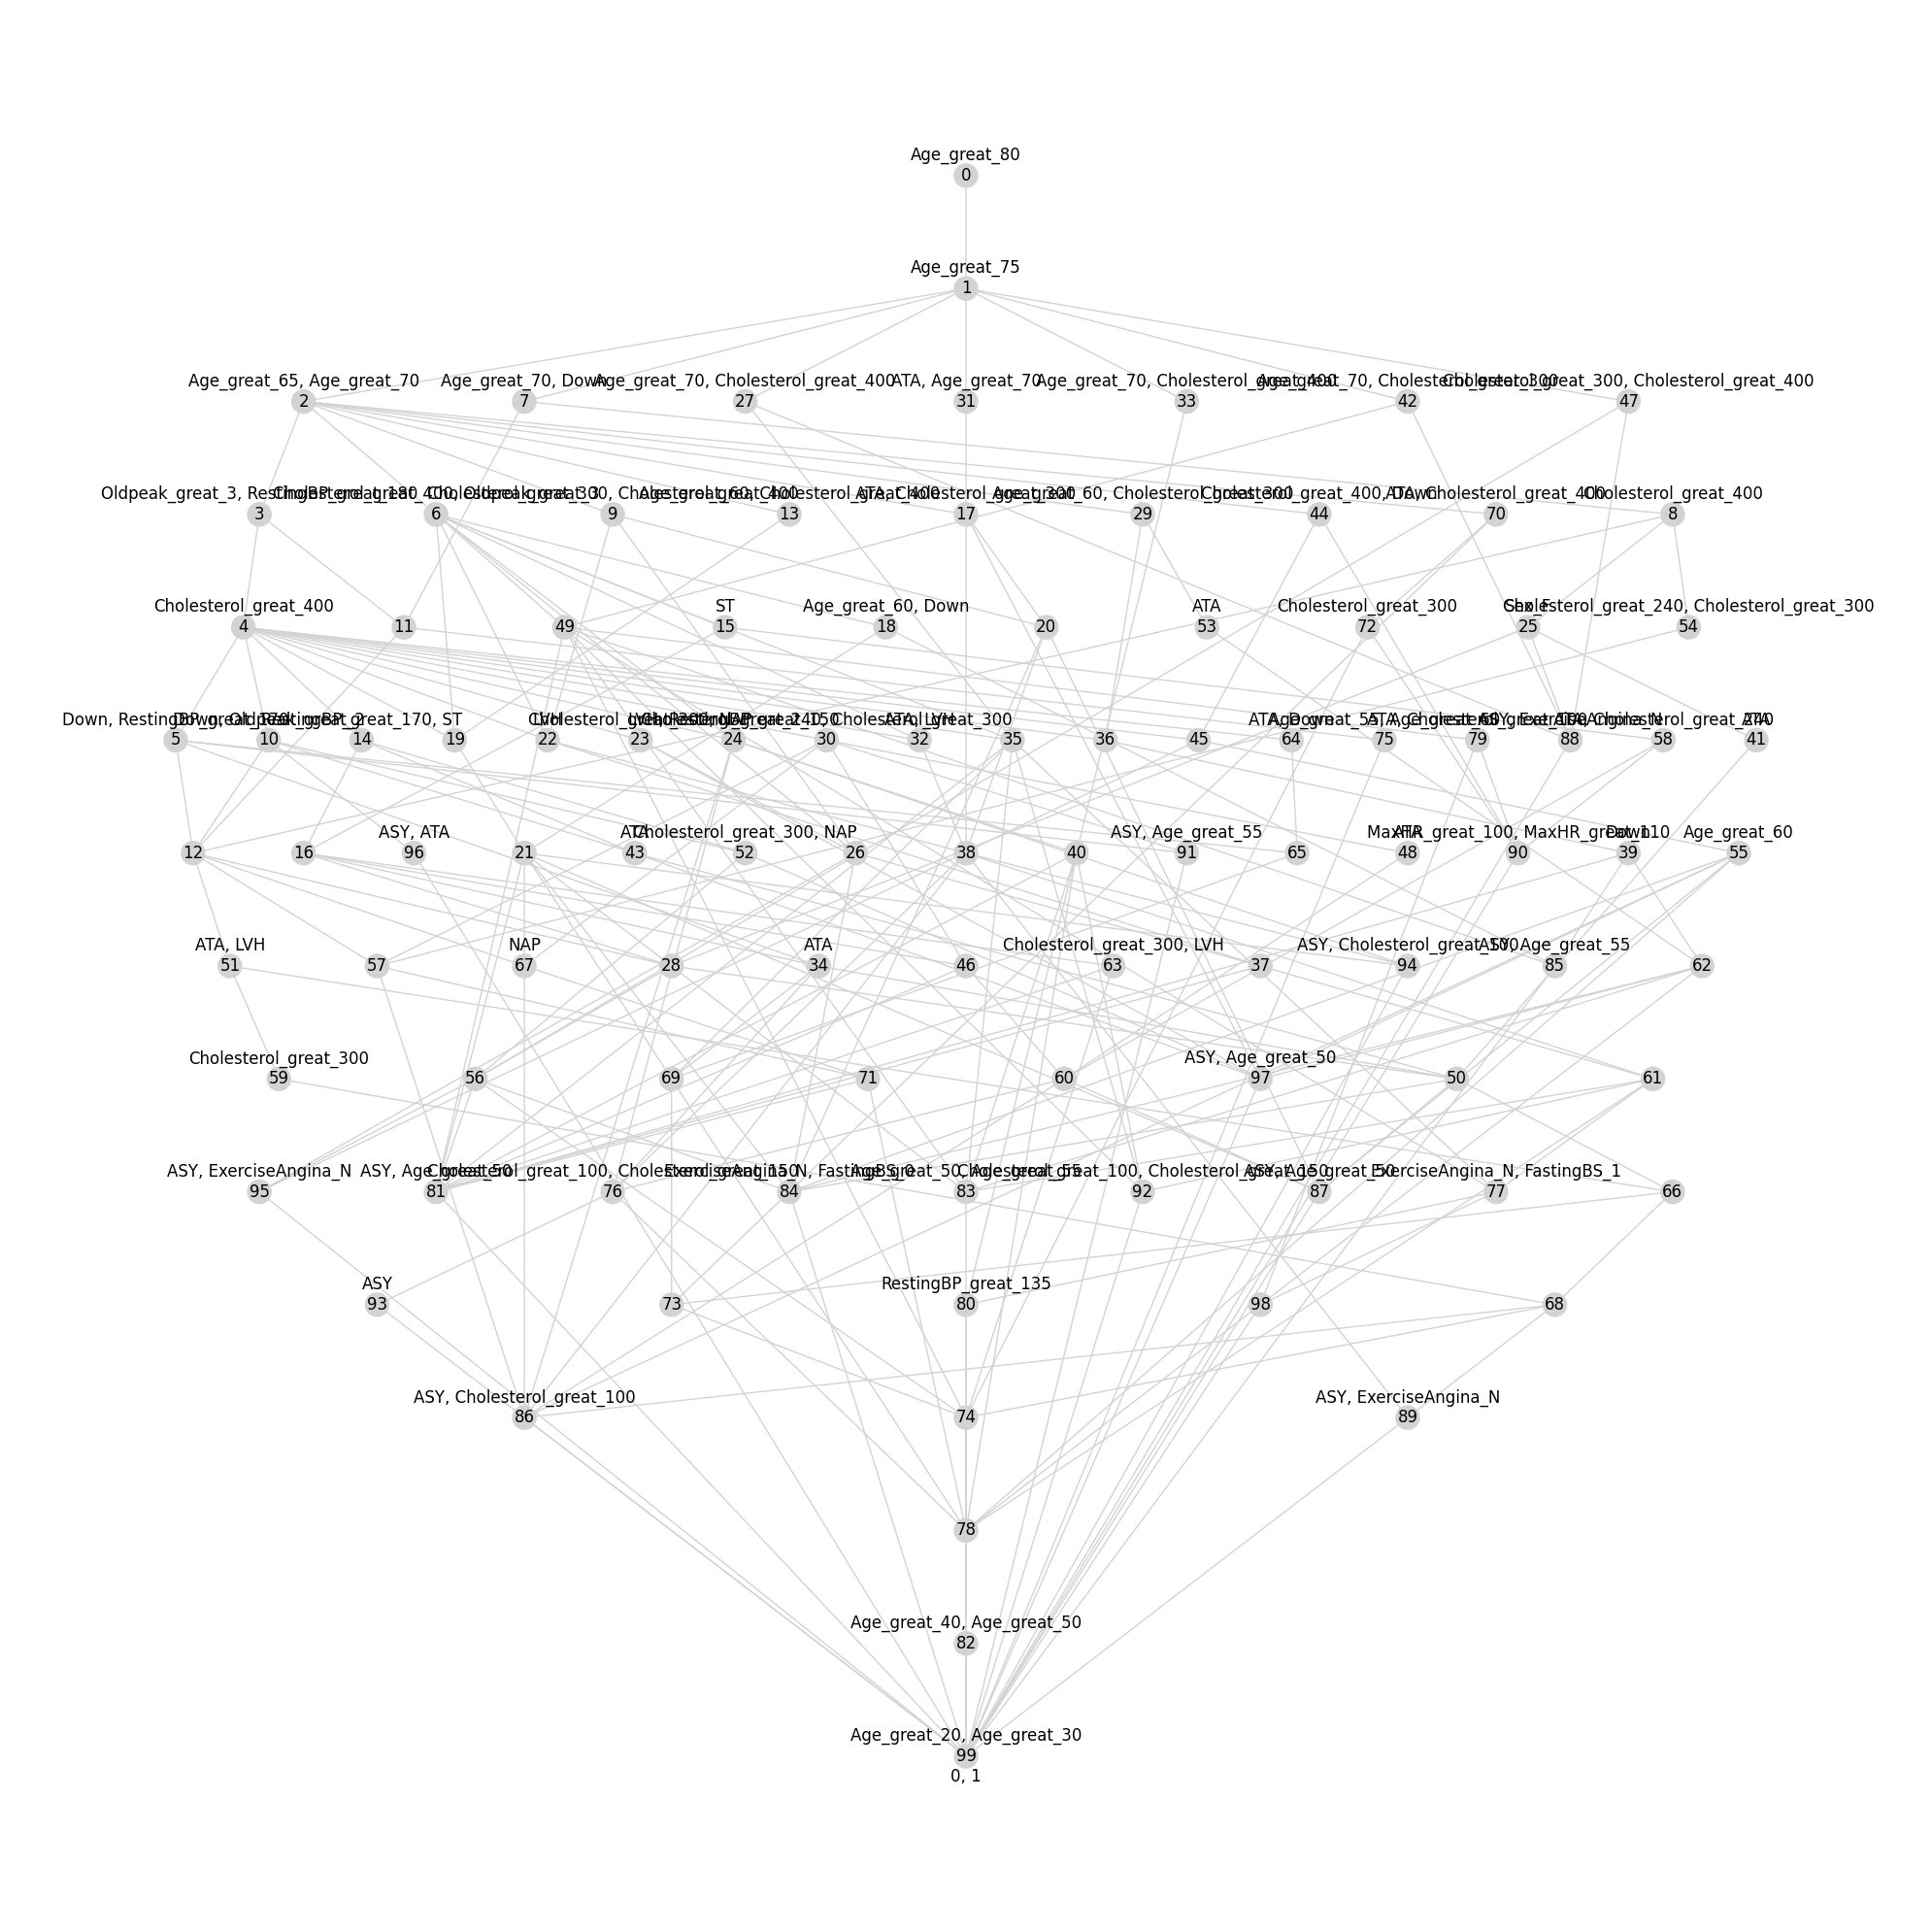

In [7]:
fig, ax = plt.subplots(figsize=(20, 20))
vsl = LineVizNx()
vsl.draw_concept_lattice(
    L,
    ax=ax,
    flg_node_indices=True,
    flg_new_intent_count_prefix=False,
    flg_new_extent_count_prefix=False,
)

plt.tight_layout()
plt.savefig(f"lattice{NUMBER}.png")
plt.show()

# Best concepts selecting

Select indices of the best concepts from the lattice

In [8]:
n_concepts = 3
while True:
    best_concepts_recall = list(L.measures['recall'].argsort()[::-1][:n_concepts])
    covered_indices = {g_i for c in L[best_concepts_recall] for g_i in c.extent_i}
    if len(covered_indices) == K_train.n_objects:
        break
    n_concepts += 1

In [9]:
best_concepts_recall

[99, 91, 98]

In [10]:
n_concepts = 3
while True:
    best_concepts_f1 = list(L.measures['f1_score'].argsort()[::-1][:n_concepts])
    covered_indices = {g_i for c in L[best_concepts_f1] for g_i in c.extent_i}
    if len(covered_indices) == K_train.n_objects:
        break
    n_concepts += 1

In [11]:
best_concepts_f1

[75, 77, 85]

# Neural network

In [12]:
def neural_network(L, best_concepts, func_nl):
    cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
    cn.fit(X_train, y_train, n_epochs=2000, nonlinearity=func_nl)

    # predicting
    y_pred = cn.predict(X_test)[1]
    # y_proba = cn.predict_proba(X_test).detach().numpy()

    # metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("----------------\n")

    return cn, recall, f1

In [13]:
nonlinearities = [torch.nn.ReLU, torch.nn.Tanh, torch.nn.Sigmoid]
bcs = [best_concepts_recall, best_concepts_f1]

In [14]:
best_nnl = None
best_estimator = None
best_metric_value = 0.0
best_bc = None
idx = 0
for nnl in nonlinearities:
    for bc in bcs:
        idx += 1
        print(f"Stage {idx}")
        print(f"Parameters: nnl={nnl}, bc={bc}")
        cn, recall, f1 = neural_network(L, bc, nnl)
        if f1 > best_metric_value:
            best_metric_value = f1
            best_nnl = nnl
            best_bc = bc
            best_estimator = cn

Stage 1
Parameters: nnl=<class 'torch.nn.modules.activation.ReLU'>, bc=[99, 91, 98]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       112
           1       0.59      1.00      0.75       164

    accuracy                           0.59       276
   macro avg       0.30      0.50      0.37       276
weighted avg       0.35      0.59      0.44       276

----------------

Stage 2
Parameters: nnl=<class 'torch.nn.modules.activation.ReLU'>, bc=[75, 77, 85]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.84       112
           1       0.91      0.87      0.89       164

    accuracy                           0.87       276
   macro avg       0.86      0.87      0.87       276
weighted avg       0.87      0.87      0.87       276

----------------

Stage 3
Parameters: nnl=<class 'torch.nn.modules.activation.Tanh'>, bc=[99, 91, 98]
Classificati

In [16]:
print(f"Best parameters")
print(f"nonlinearity={best_nnl}")
print(f"best concepts={best_bc}")
print()
y_pred = best_estimator.predict(X_test)[1]
print(classification_report(y_test, y_pred))
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Recall: {recall}")
print(f"F1: {f1}")

Best parameters
nonlinearity=<class 'torch.nn.modules.activation.Sigmoid'>
best concepts=[99, 91, 98]

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       112
           1       0.90      0.91      0.91       164

    accuracy                           0.89       276
   macro avg       0.88      0.88      0.88       276
weighted avg       0.89      0.89      0.89       276

Recall: 0.9085365853658537
F1: 0.9057750759878419


In [17]:
cn = best_estimator

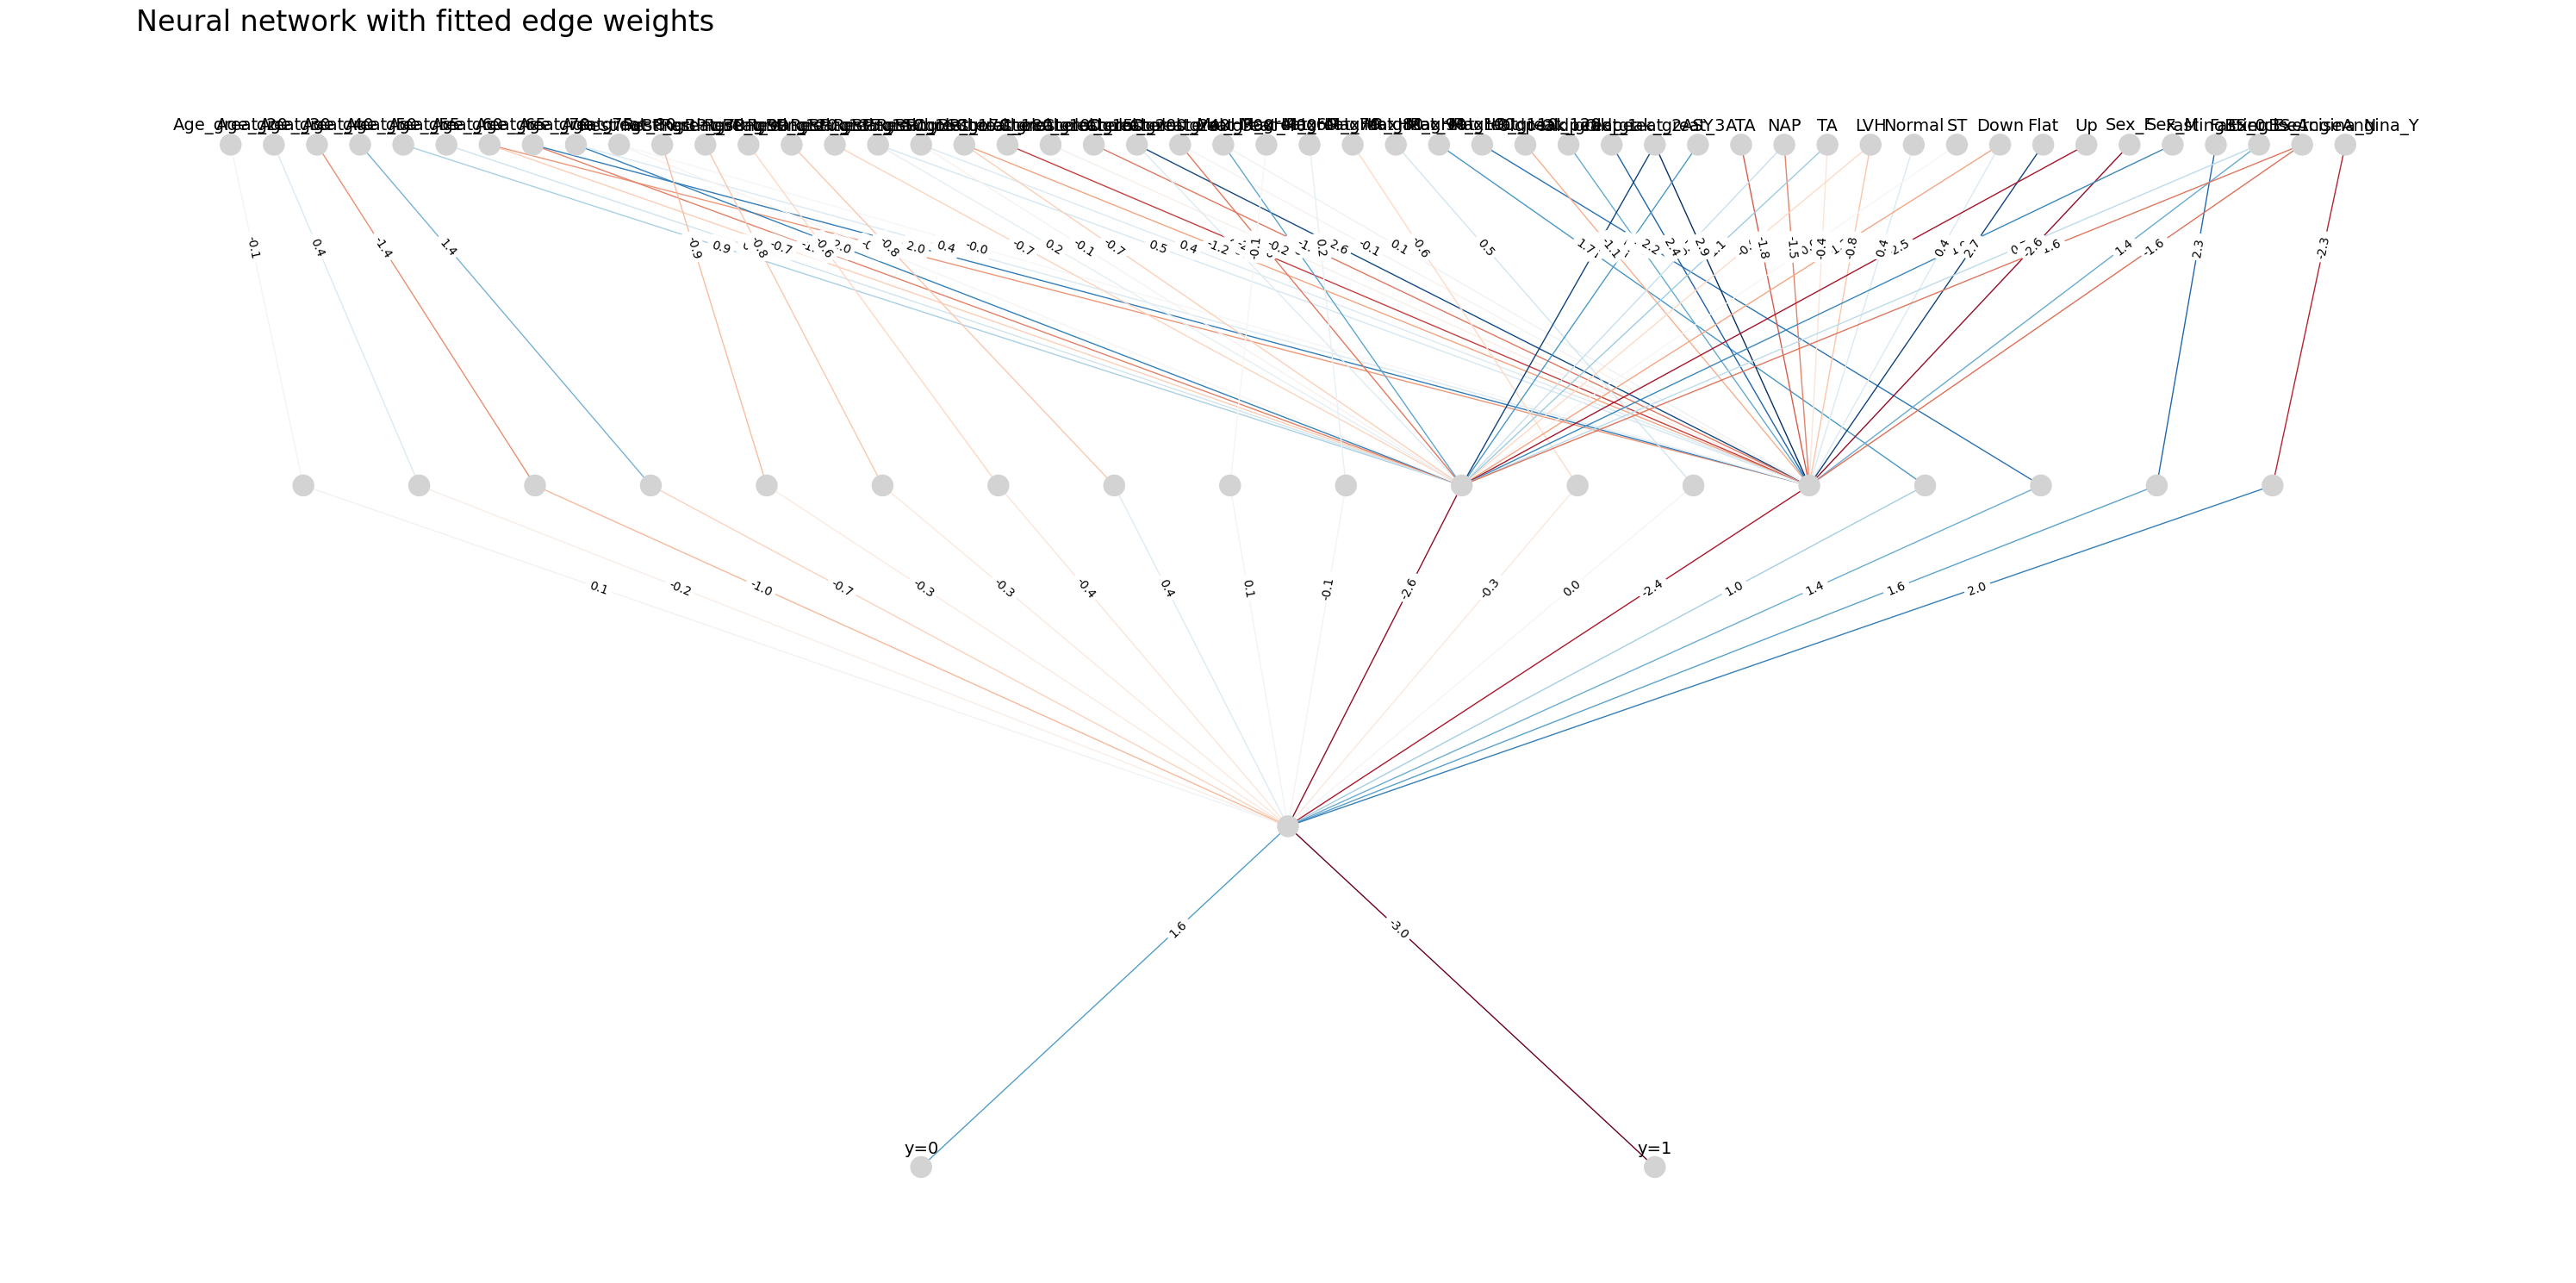

In [18]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(
        el_i, P, set(cn.attributes)
    )
    + "\n\n",
)
edge_weights = cn.edge_weights_from_network()

fig, ax = plt.subplots(figsize=(30, 15))

vis.draw_poset(
    cn.poset,
    ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(
        el_i, P, set(cn.attributes), only_new_attrs=True
    )
    + "\n\n",
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(
    cn.poset.to_networkx(),
    vis.mover.pos,
    {k: f"{v:.1f}" for k, v in edge_weights.items()},
    label_pos=0.7,
)

plt.title("Neural network with fitted edge weights", size=24, x=0.05, loc="left")
plt.tight_layout()
plt.subplots_adjust()
plt.savefig(
    f"fitted_network{NUMBER}.png"
)
plt.show()